In [42]:
# Importing Necessary Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
import keras.backend as K

In [43]:
#Upload files
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dadulrishan","key":"779b6b4722ecb849b78e947efdbe85c2"}'}

In [44]:
# Make the .kaggle directory
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [45]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
fer2013.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip fer2013.zip -d fer2013

In [47]:
!ls

 best_model.keras	        sample_data			    train
 emotion_recognition_model.h5  'Screenshot 2024-12-25 131534.png'   train_metadata.txt
 fer2013.zip		        test				    valid_metadata.txt
 model_architecture.png         test_metadata.txt


In [48]:
# Verify dataset paths

import os
def check_dataset_paths(train_dir, test_dir):
    if not os.path.exists(train_dir):
        raise FileNotFoundError(f"Training directory {train_dir} not found.")
    if not os.path.exists(test_dir):
        raise FileNotFoundError(f"Test directory {test_dir} not found.")
    print("Dataset paths verified. Training and test directories exist.")

TRAIN_DIR = '/content/train'
TEST_DIR = '/content/test'

check_dataset_paths(TRAIN_DIR, TEST_DIR)

Dataset paths verified. Training and test directories exist.


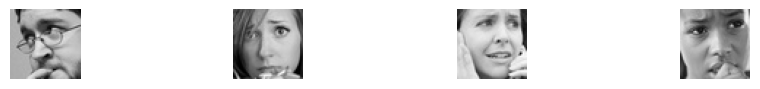

In [49]:
#Preview Images from Dataset
import random
import os
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt

def preview_images(data_dir, num_images=4):
    cls = random.choice(os.listdir(data_dir))
    cls_path = os.path.join(data_dir, cls)
    image_names = random.sample(os.listdir(cls_path), min(num_images, len(os.listdir(cls_path))))

    fig, axes = plt.subplots(1, num_images, figsize=(10, 1))
    for ax, img_name in zip(axes, image_names):
        img_path = os.path.join(cls_path, img_name)
        ax.imshow(load_img(img_path))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

preview_images(TRAIN_DIR)

<ipython-input-50-2c542275cc3a>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_labels, y=class_counts, palette="viridis")


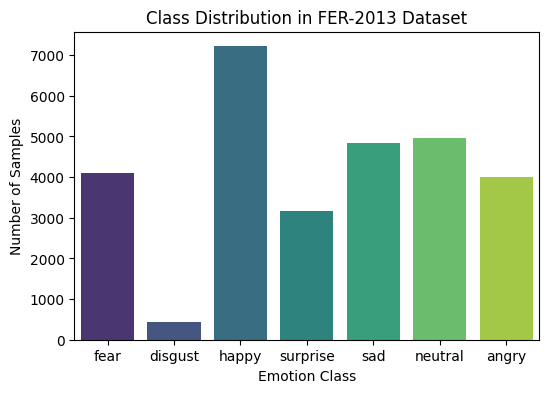

In [50]:
#Bar Plot of Class Distribution
import seaborn as sns
import matplotlib.pyplot as plt
import os

TRAIN_DIR = '/content/train'
class_labels = os.listdir(TRAIN_DIR)
class_counts = [len(os.listdir(os.path.join(TRAIN_DIR, label))) for label in class_labels]

plt.figure(figsize=(6, 4))
sns.barplot(x=class_labels, y=class_counts, palette="viridis")
plt.title('Class Distribution in FER-2013 Dataset')
plt.xlabel('Emotion Class')
plt.ylabel('Number of Samples')
plt.show()

In [51]:
#Create Data Generators
def create_data_generators():
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        brightness_range=[0.8, 1.2],
        horizontal_flip=True,
        fill_mode='nearest'
    )

    valid_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2
    )

    test_datagen = ImageDataGenerator(rescale=1./255)

    return train_datagen, valid_datagen, test_datagen

train_datagen, valid_datagen, test_datagen = create_data_generators()

In [52]:
# Creating Data Sets
train_dataset = train_datagen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(48, 48),
    batch_size=64,
    class_mode='categorical',
    subset='training'
)

valid_dataset = valid_datagen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(48, 48),
    batch_size=64,
    class_mode='categorical',
    subset='validation'
)

test_dataset = test_datagen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(48, 48),
    batch_size=64,
    class_mode='categorical'
)


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


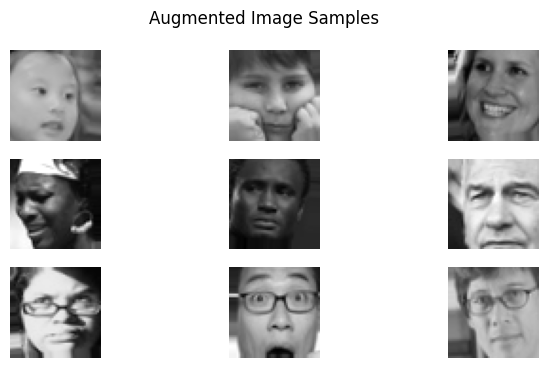

In [53]:
# Display augmented images
augmented_images, _ = next(train_dataset)
plt.figure(figsize=(8, 4))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i])
    plt.axis('off')
plt.suptitle('Augmented Image Samples')
plt.show()

In [54]:
# Display statistics
def dataset_statistics(dataset):
    class_counts = dataset.classes
    class_labels = list(dataset.class_indices.keys())
    total_images = len(class_counts)
    class_distribution = pd.Series(class_counts).value_counts()

    print(f"Total Images: {total_images}")
    print("Class Distribution:")
    for label, count in zip(class_labels, class_distribution):
        print(f"{label}: {count}")

dataset_statistics(train_dataset)

Total Images: 22968
Class Distribution:
angry: 5772
disgust: 3972
fear: 3864
happy: 3278
neutral: 3196
sad: 2537
surprise: 349


Training Batch Preview:


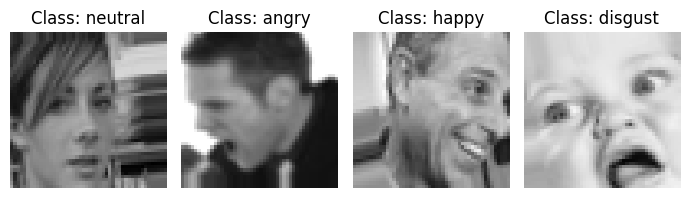

Validation Batch Preview:


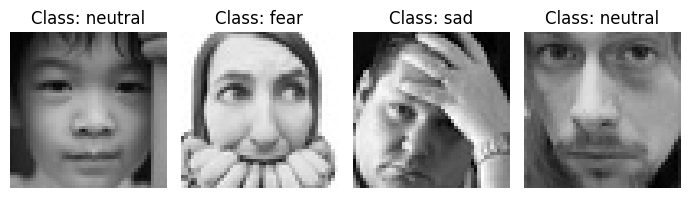

In [55]:
# Preview batches
def preview_batch(dataset, num_images=4):
    images, labels = next(dataset)
    class_indices = {v: k for k, v in dataset.class_indices.items()}  # Reverse class mapping
    fig, axes = plt.subplots(1, num_images, figsize=(7, 5))
    for img, lbl, ax in zip(images[:num_images], labels[:num_images], axes):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"Class: {class_indices[np.argmax(lbl)]}")
    plt.tight_layout()
    plt.show()

print("Training Batch Preview:")
preview_batch(train_dataset)

print("Validation Batch Preview:")
preview_batch(valid_dataset)


Class Distribution imbalance:


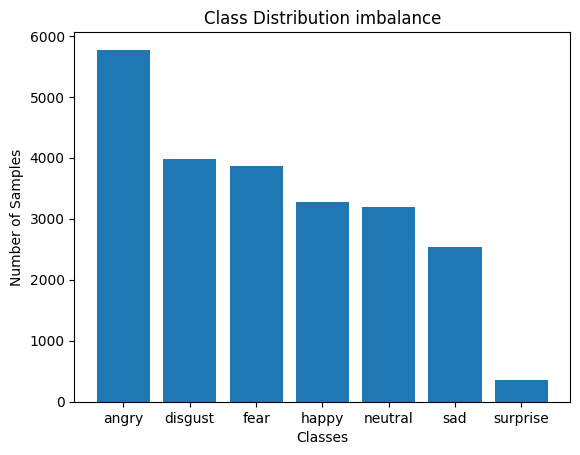

In [56]:
# Check for class imbalance
def check_class_imbalance(dataset):
    class_counts = pd.Series(dataset.classes).value_counts()
    class_labels = list(dataset.class_indices.keys())
    plt.bar(class_labels, class_counts)
    plt.title("Class Distribution imbalance")
    plt.xlabel("Classes")
    plt.ylabel("Number of Samples")
    plt.show()

print("Class Distribution imbalance:")
check_class_imbalance(train_dataset)

In [57]:
# Save metadata
def save_metadata(dataset, filename):
    metadata = {
        "class_indices": dataset.class_indices,
        "num_classes": len(dataset.class_indices),
        "total_images": len(dataset.classes)
    }
    with open(filename, "w") as f:
        f.write(str(metadata))
    print(f"Metadata saved to {filename}")

save_metadata(train_dataset, "train_metadata.txt")
save_metadata(valid_dataset, "valid_metadata.txt")
save_metadata(test_dataset, "test_metadata.txt")

Metadata saved to train_metadata.txt
Metadata saved to valid_metadata.txt
Metadata saved to test_metadata.txt


In [58]:
# Model Definition
from tensorflow.keras.regularizers import l2
def build_model():
    base_model = VGG16(input_shape=(48, 48, 3), include_top=False, weights="imagenet")
    for layer in base_model.layers[:-4]:
        layer.trainable = False

    model = Sequential([
    base_model,
    Flatten(),
    Dense(256, kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.6),
    Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.6),
    Dense(7, activation='softmax')
])

    return model

model = build_model()
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 1, 1, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,881,351 (56.77 MB)

 Trainable params: 7,245,319 (27.64 MB)

 Non-trainable params: 7,636,032 (29.13 MB)

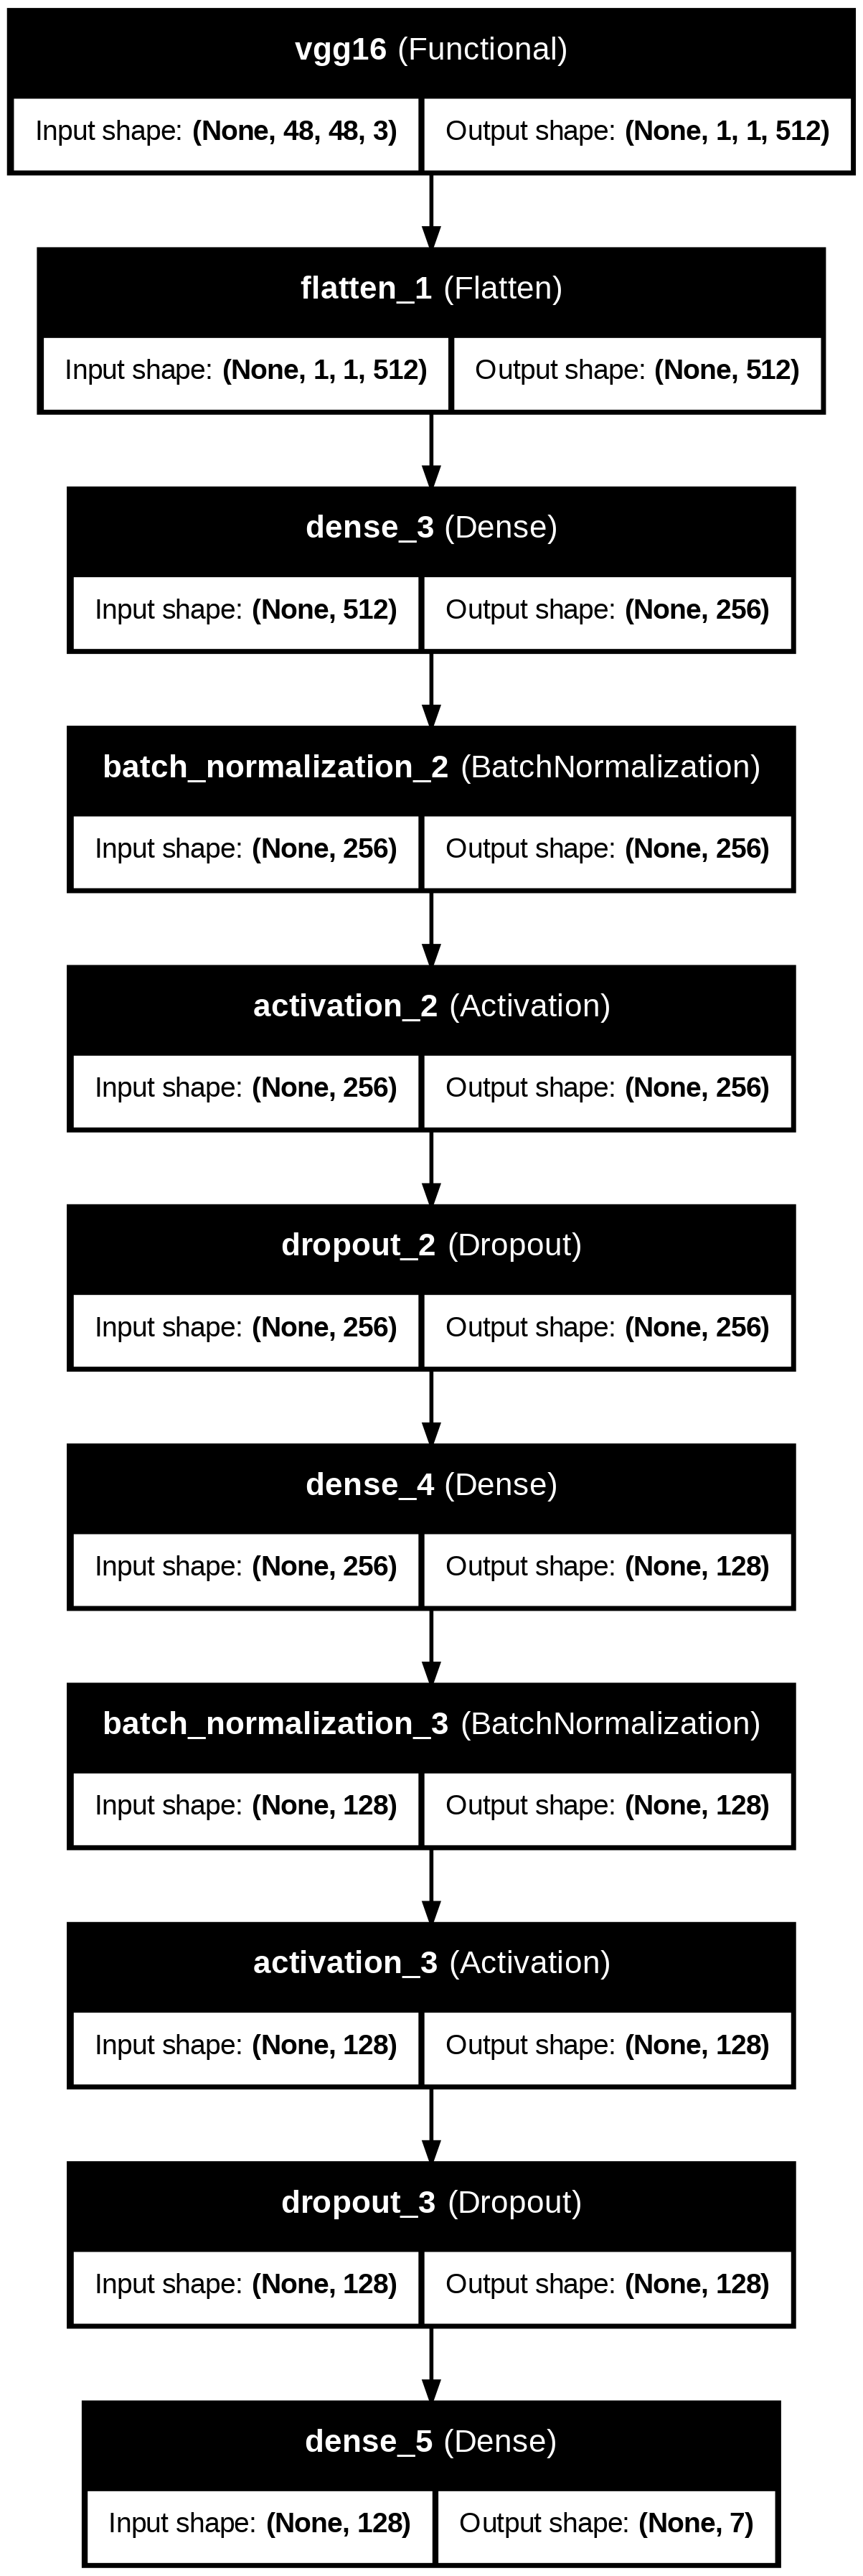

In [59]:
# Save and display the model architecture
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


In [60]:
#Custom metrics and model compilation for emotion detection.
import tensorflow.keras.backend as K

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    f1_score
]

# Compile with Categorical Crossentropy Loss
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=METRICS
)



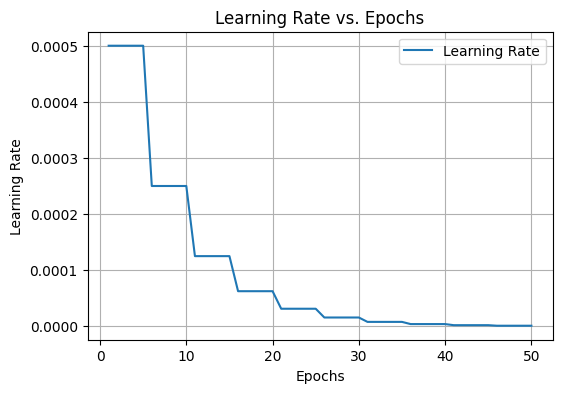

In [61]:
# Extract learning rate history from the ReduceLROnPlateau callback
lrs = [0.0005 * (0.5 ** (i // 5)) for i in range(50)]

plt.figure(figsize=(6, 4))
plt.plot(range(1, len(lrs) + 1), lrs, label='Learning Rate')
plt.title('Learning Rate vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.grid()
plt.legend()
plt.show()


In [62]:
# Define callbacks for efficient training and model optimization
lrd = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, factor=0.5, min_lr=1e-6)
es = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
mcp = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')

In [63]:
# Train the model with defined callbacks for optimization and validation tracking
history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=50,
    callbacks=[lrd, es, mcp],
    verbose=1
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


359/359 ━━━━━━━━━━━━━━━━━━━━ 46s 109ms/step - accuracy: 0.1932 - auc: 0.5706 - f1_score: 0.1217 - loss: 3.2138 - precision: 0.2137 - recall: 0.0855 - val_accuracy: 0.2689 - val_auc: 0.6568 - val_f1_score: 0.1876 - val_loss: 2.8459 - val_precision: 0.3300 - val_recall: 0.1317 - learning_rate: 1.0000e-04
Epoch 2/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 34s 93ms/step - accuracy: 0.3091 - auc: 0.6968 - f1_score: 0.2318 - loss: 2.6203 - precision: 0.4067 - recall: 0.1626 - val_accuracy: 0.3735 - val_auc: 0.7659 - val_f1_score: 0.3470 - val_loss: 2.3956 - val_precision: 0.4498 - val_recall: 0.2834 - learning_rate: 1.0000e-04
Epoch 3/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 35s 95ms/step - accuracy: 0.3516 - auc: 0.7347 - f1_score: 0.2623 - loss: 2.3937 - precision: 0.4748 - recall: 0.1821 - val_accuracy: 0.4635 - val_auc: 0.8192 - val_f1_score: 0.3690 - val_loss: 2.0263 - val_precision: 0.6540 - val_recall: 0.2588 - learning_rate: 1.0000e-04
Epoch 4/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 35s 94ms/step - accuracy: 0.

In [64]:
#Evaluate the model on the test dataset and print key performance metrics.
test_loss, test_accuracy, test_precision, test_recall, test_auc, test_f1 = model.evaluate(test_dataset, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test AUC: {test_auc}")
print(f"Test F1 Score: {test_f1}")


113/113 - 3s - 28ms/step - accuracy: 0.5705 - auc: 0.8826 - f1_score: 0.5413 - loss: 1.3272 - precision: 0.6778 - recall: 0.4508
Test Loss: 1.3272061347961426
Test Accuracy: 0.5704931616783142
Test Precision: 0.6778382658958435
Test Recall: 0.45082196593284607
Test AUC: 0.8826203942298889
Test F1 Score: 0.5413339734077454


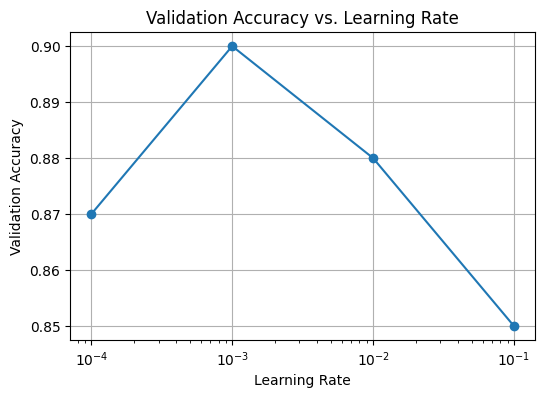

In [65]:
# Example validation accuracies for different learning rates
learning_rates = [0.1, 0.01, 0.001, 0.0001]
val_accuracies = [0.85, 0.88, 0.90, 0.87]

plt.figure(figsize=(6, 4))
plt.plot(learning_rates, val_accuracies, marker='o')
plt.xscale('log')
plt.title('Validation Accuracy vs. Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy')
plt.grid()
plt.show()


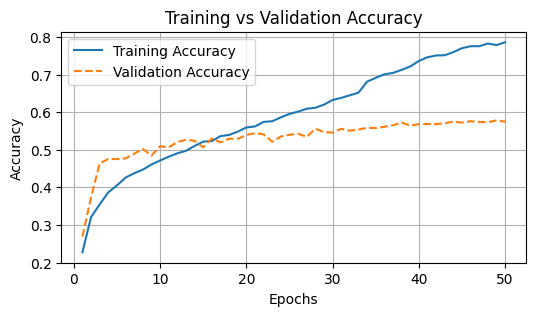

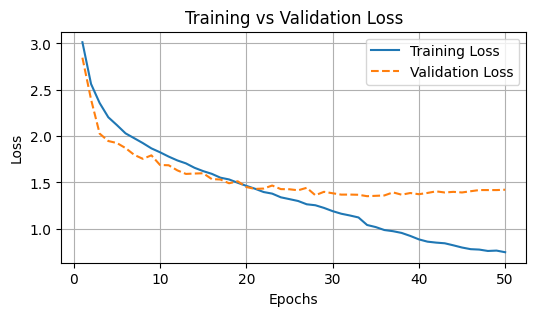

In [66]:
# Plot training and validation accuracy to visualize model performance across epochs
# Plot training and validation loss to assess convergence and overfitting trends
epochs = range(1, len(history.history['accuracy']) + 1)


train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(6, 3))
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', linestyle='--')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(6, 3))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss', linestyle='--')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


225/225 - 3s - 15ms/step - accuracy: 0.5705 - auc: 0.8826 - f1_score: 0.5392 - loss: 1.3272 - precision: 0.6778 - recall: 0.4508
Test Loss: 1.3272069692611694
Test Accuracy: 0.5704931616783142
Test Precision: 0.6778382658958435
Test Recall: 0.45082196593284607
Test AUC: 0.8826204538345337
Test F1 Score: 0.5391762852668762
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.41      0.60      0.49       958
           1       0.64      0.47      0.54       111
           2       0.45      0.38      0.41      1024
           3       0.75      0.77      0.76      1774
           4       0.54      0.48      0.51      1233
           5       0.48      0.40      0.44      1247
           6       0.71      0.74      0.72       831

    accuracy                           0.57      7178
   macro avg       0.57      0.55      0.55      7178
weighted avg       0.57      0.57      0.57      7178



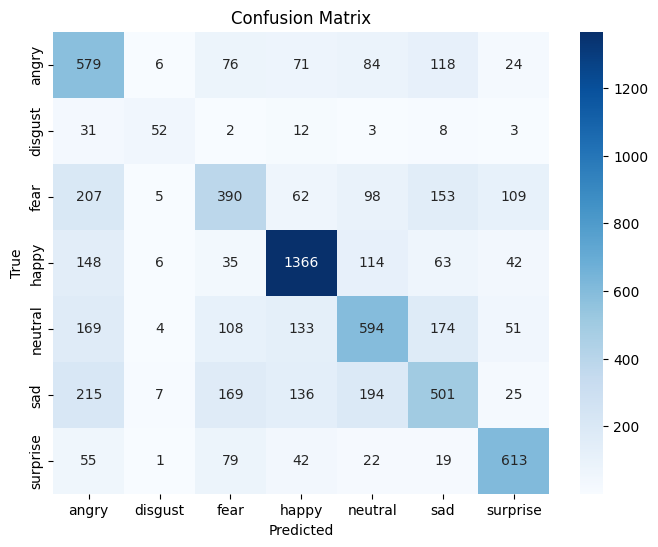

Test ROC-AUC: 0.86


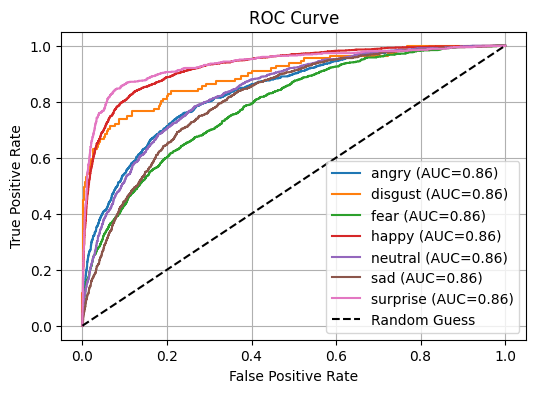

In [67]:
#Evaluate model, generate predictions, and visualize results (confusion matrix & ROC curve).
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

X_test, y_test = [], []
for i in range(len(test_dataset)):
    images, labels = test_dataset[i]
    X_test.extend(images)
    y_test.extend(labels)

X_test = np.array(X_test)
y_test = np.array(y_test)

test_loss, test_accuracy, test_precision, test_recall, test_auc, test_f1 = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test AUC: {test_auc}")
print(f"Test F1 Score: {test_f1}")

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)


print("\nClassification Report:\n")
print(classification_report(y_true, y_pred))


conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_dataset.class_indices.keys(),
            yticklabels=test_dataset.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

auc = roc_auc_score(y_test, y_pred_probs, multi_class="ovr")
print(f"Test ROC-AUC: {auc:.2f}")
plt.figure(figsize=(6, 4))
for i, class_name in enumerate(test_dataset.class_indices.keys()):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_probs[:, i])
    plt.plot(fpr, tpr, label=f"{class_name} (AUC={auc:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="best")
plt.grid()
plt.show()

718/718 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step


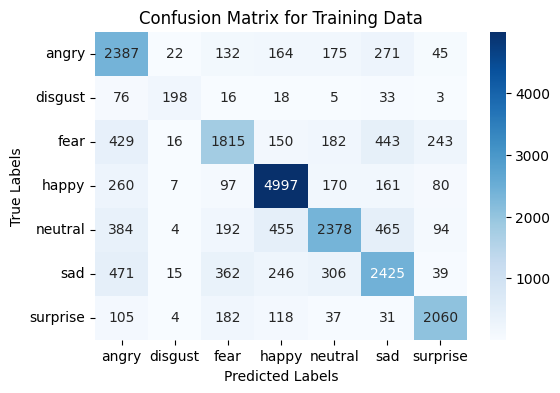

In [68]:
## Generate predictions for training data and visualize the confusion matrix.
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

X_train, y_train = [], []
for i in range(len(train_dataset)):
    images, labels = train_dataset[i]
    X_train.extend(images)
    y_train.extend(labels)

X_train = np.array(X_train)
y_train = np.array(y_train)

y_train_pred_probs = model.predict(X_train)
y_train_pred = np.argmax(y_train_pred_probs, axis=1)
y_train_true = np.argmax(y_train, axis=1)

conf_matrix = confusion_matrix(y_train_true, y_train_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=train_dataset.class_indices.keys(),
            yticklabels=train_dataset.class_indices.keys())
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Training Data")
plt.show()


In [69]:
# Save the model in .h5 format
model.save('emotion_recognition_model.h5')
print("Model saved as emotion_recognition_model.h5")



Model saved as emotion_recognition_model.h5


In [70]:
#Load Model
from tensorflow.keras.models import load_model

loaded_model = load_model('emotion_recognition_model.h5')
print("Model successfully loaded.")
metrics = loaded_model.evaluate(valid_dataset, verbose=2)
val_loss = metrics[0]
val_accuracy = metrics[1]

print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

Model successfully loaded.
90/90 - 4s - 49ms/step - accuracy: 0.5583 - auc: 0.8782 - f1_score: 0.5271 - loss: 1.3512 - precision: 0.6699 - recall: 0.4430
Validation Loss: 1.3511639833450317
Validation Accuracy: 0.5582650899887085


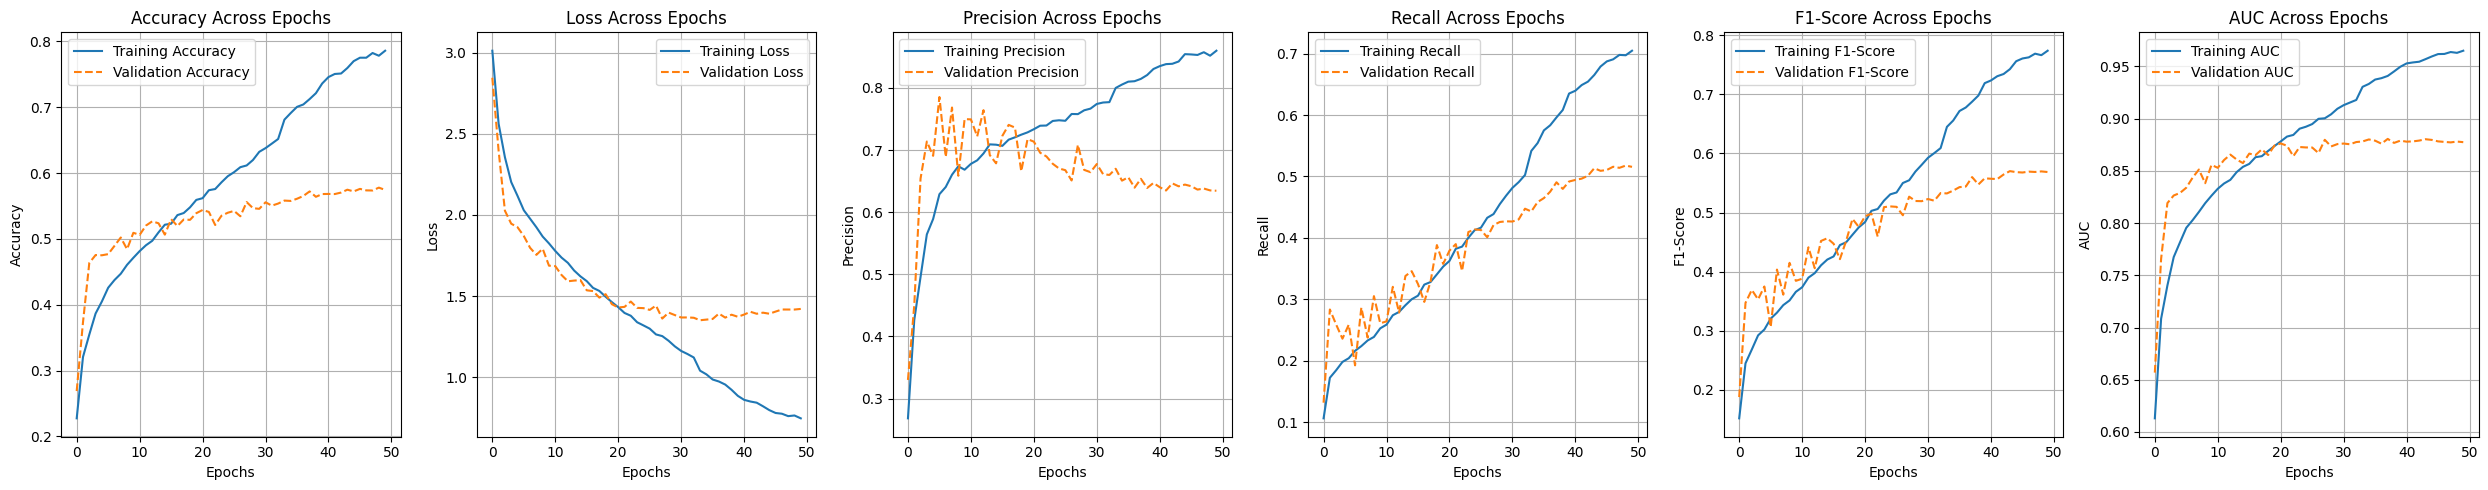

In [71]:
## Plot training and validation metrics (accuracy, loss, precision, recall, F1-score, AUC) across epochs for visual comparison.
import matplotlib.pyplot as plt

metrics = ['accuracy', 'loss', 'precision', 'recall', 'f1_score', 'auc']
titles = ['Accuracy', 'Loss', 'Precision', 'Recall', 'F1-Score', 'AUC']
y_labels = ['Accuracy', 'Loss', 'Precision', 'Recall', 'F1-Score', 'AUC']
fig, axes = plt.subplots(1, len(metrics), figsize=(25, 5))

for i, metric in enumerate(metrics):
    axes[i].plot(history.history[metric], label=f'Training {titles[i]}')
    axes[i].plot(history.history[f'val_{metric}'], label=f'Validation {titles[i]}', linestyle='--')
    axes[i].set_title(f'{titles[i]} Across Epochs')
    axes[i].set_xlabel('Epochs')
    axes[i].set_ylabel(y_labels[i])
    axes[i].legend()
    axes[i].grid()

plt.tight_layout()
plt.show()


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


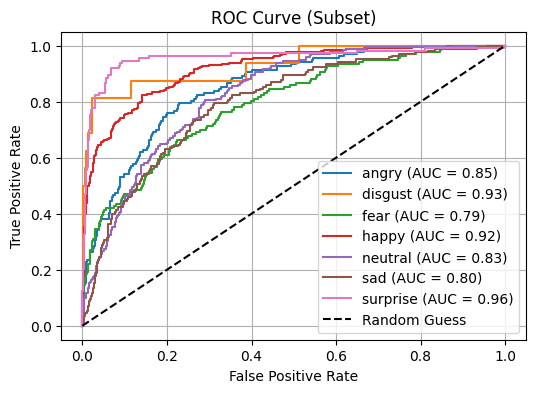

In [72]:
#ROC Curve
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

subset_size = 1000
X_test, y_test = [], []

for i, (images, labels) in enumerate(test_dataset):
    X_test.extend(images)
    y_test.extend(labels)
    if len(X_test) >= subset_size:
        break

X_test = np.array(X_test[:subset_size])
y_test = np.array(y_test[:subset_size])

y_pred_probs = model.predict(X_test)

emotion_labels = {v: k for k, v in test_dataset.class_indices.items()}

plt.figure(figsize=(6, 4))
num_classes = y_test.shape[1]
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{emotion_labels[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.title("ROC Curve (Subset)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()


113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step


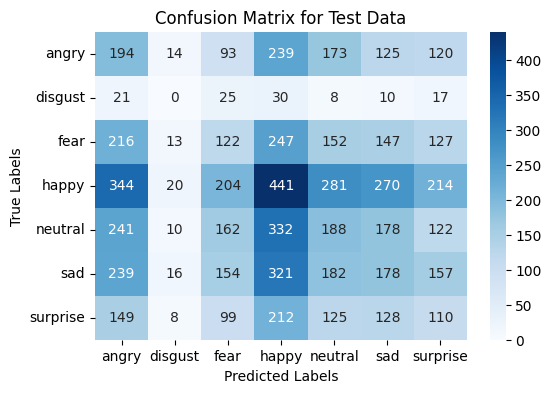

In [73]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


y_test_pred_probs = model.predict(test_dataset, verbose=1)
y_test_pred = np.argmax(y_test_pred_probs, axis=1)

y_test_true = test_dataset.classes

conf_matrix = confusion_matrix(y_test_true, y_test_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_dataset.class_indices.keys(),
            yticklabels=test_dataset.class_indices.keys())
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Test Data")
plt.show()


180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


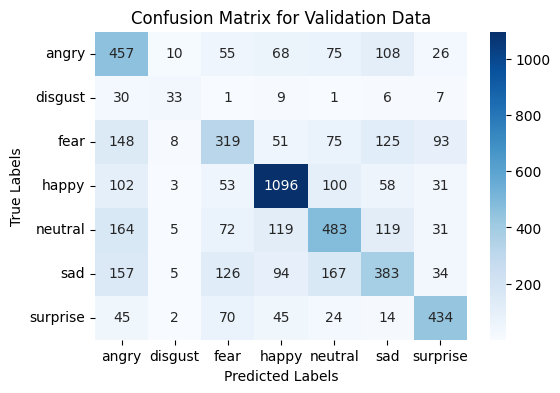

In [74]:
X_val, y_val = [], []
for i in range(len(valid_dataset)):
    images, labels = valid_dataset[i]
    X_val.extend(images)
    y_val.extend(labels)

X_val = np.array(X_val)
y_val = np.array(y_val)

y_val_pred_probs = model.predict(X_val)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)
y_val_true = np.argmax(y_val, axis=1)

conf_matrix = confusion_matrix(y_val_true, y_val_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=valid_dataset.class_indices.keys(),
            yticklabels=valid_dataset.class_indices.keys())
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Validation Data")
plt.show()


Saving Screenshot 2024-12-25 131534.png to Screenshot 2024-12-25 131534 (1).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


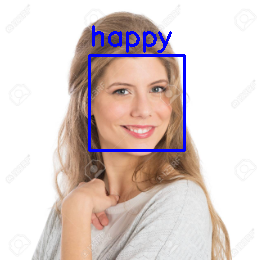

In [76]:
#Real time analysis using OpenCV
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from google.colab.patches import cv2_imshow
from google.colab import files

model = load_model('emotion_recognition_model.h5')
labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def predict_emotions(image_path):

    image = cv2.imread(image_path)
    gray_frame = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    for (x, y, w, h) in faces:
        face = gray_frame[y:y+h, x:x+w]
        face = cv2.resize(face, (48, 48))


        face = cv2.cvtColor(face, cv2.COLOR_GRAY2RGB)
        face = face / 255.0
        face = np.reshape(face, (1, 48, 48, 3))
        predictions = model.predict(face)
        emotion = labels[np.argmax(predictions)]

        cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)
        cv2.putText(image, emotion, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    cv2_imshow(image)

uploaded = files.upload()
image_path = next(iter(uploaded.keys()))

predict_emotions(image_path)